### Configuration

In [1]:
# Importing NumCosmo
import os
import sys
import gi

gi.require_version('NumCosmo', '1.0')
gi.require_version('NumCosmoMath', '1.0')
from gi.repository import GObject
from gi.repository import NumCosmo as Nc
from gi.repository import NumCosmoMath as Ncm

os.environ['CLMM_MODELING_BACKEND'] = 'nc'

__name__ = "NcContext"

Ncm.cfg_init ()
Ncm.cfg_set_log_handler (lambda msg: sys.stdout.write (msg) and sys.stdout.flush ())

#Importing Numpy and SciPy
import numpy as np
import scipy as sp
from numpy import random

# Importing matplotlib
import matplotlib.pyplot as plt

plt.rcParams['text.latex.preamble'] = [r'\usepackage{pxfonts, mathpazo}']
plt.rc('text', usetex=True)

### Building samples and underlying distributions

In [2]:
# Setting seed
np.random.seed(0)

# Defining PDFs
def gaussian_pdf(x):
    return np.exp(-x**2 / 2) / (np.sqrt(2*np.pi))

def uniform_pdf(x):
    return np.ones(np.shape(x))

def gamma_pdf(x):
    return (x * np.exp(-x)) / sp.special.gamma(2)

# Creating random samples
ndata = 10000

g_samples = []
u_samples = []
y_samples = []

for i in range(ndata):
    g_samples.append(np.random.normal(0))
    u_samples.append(np.random.uniform(0, 1))
    y_samples.append(np.random.gamma(2))

### Creating control and test KDEs

In [3]:
# Creating control KDE with RoT
kernel_control = Ncm.StatsDistKernelGauss.new(3)
kde_control    = Ncm.StatsDistKDE.new(kernel_control, Ncm.StatsDistCV.NONE)

for i in range(ndata):
    kde_control.add_obs(Ncm.Vector.new_array([g_samples[i], u_samples[i], y_samples[i]]))

kde_control.prepare()

# Creating test KDE with LOO
kernel_test = Ncm.StatsDistKernelGauss.new(3)
kde_test    = Ncm.StatsDistKDE.new(kernel_test, Ncm.StatsDistCV.LOO)

for i in range(ndata):
    kde_test.add_obs(Ncm.Vector.new_array([g_samples[i], u_samples[i], y_samples[i]]))

kde_test.prepare()

### Plotting KDEs against histograms and real distributions

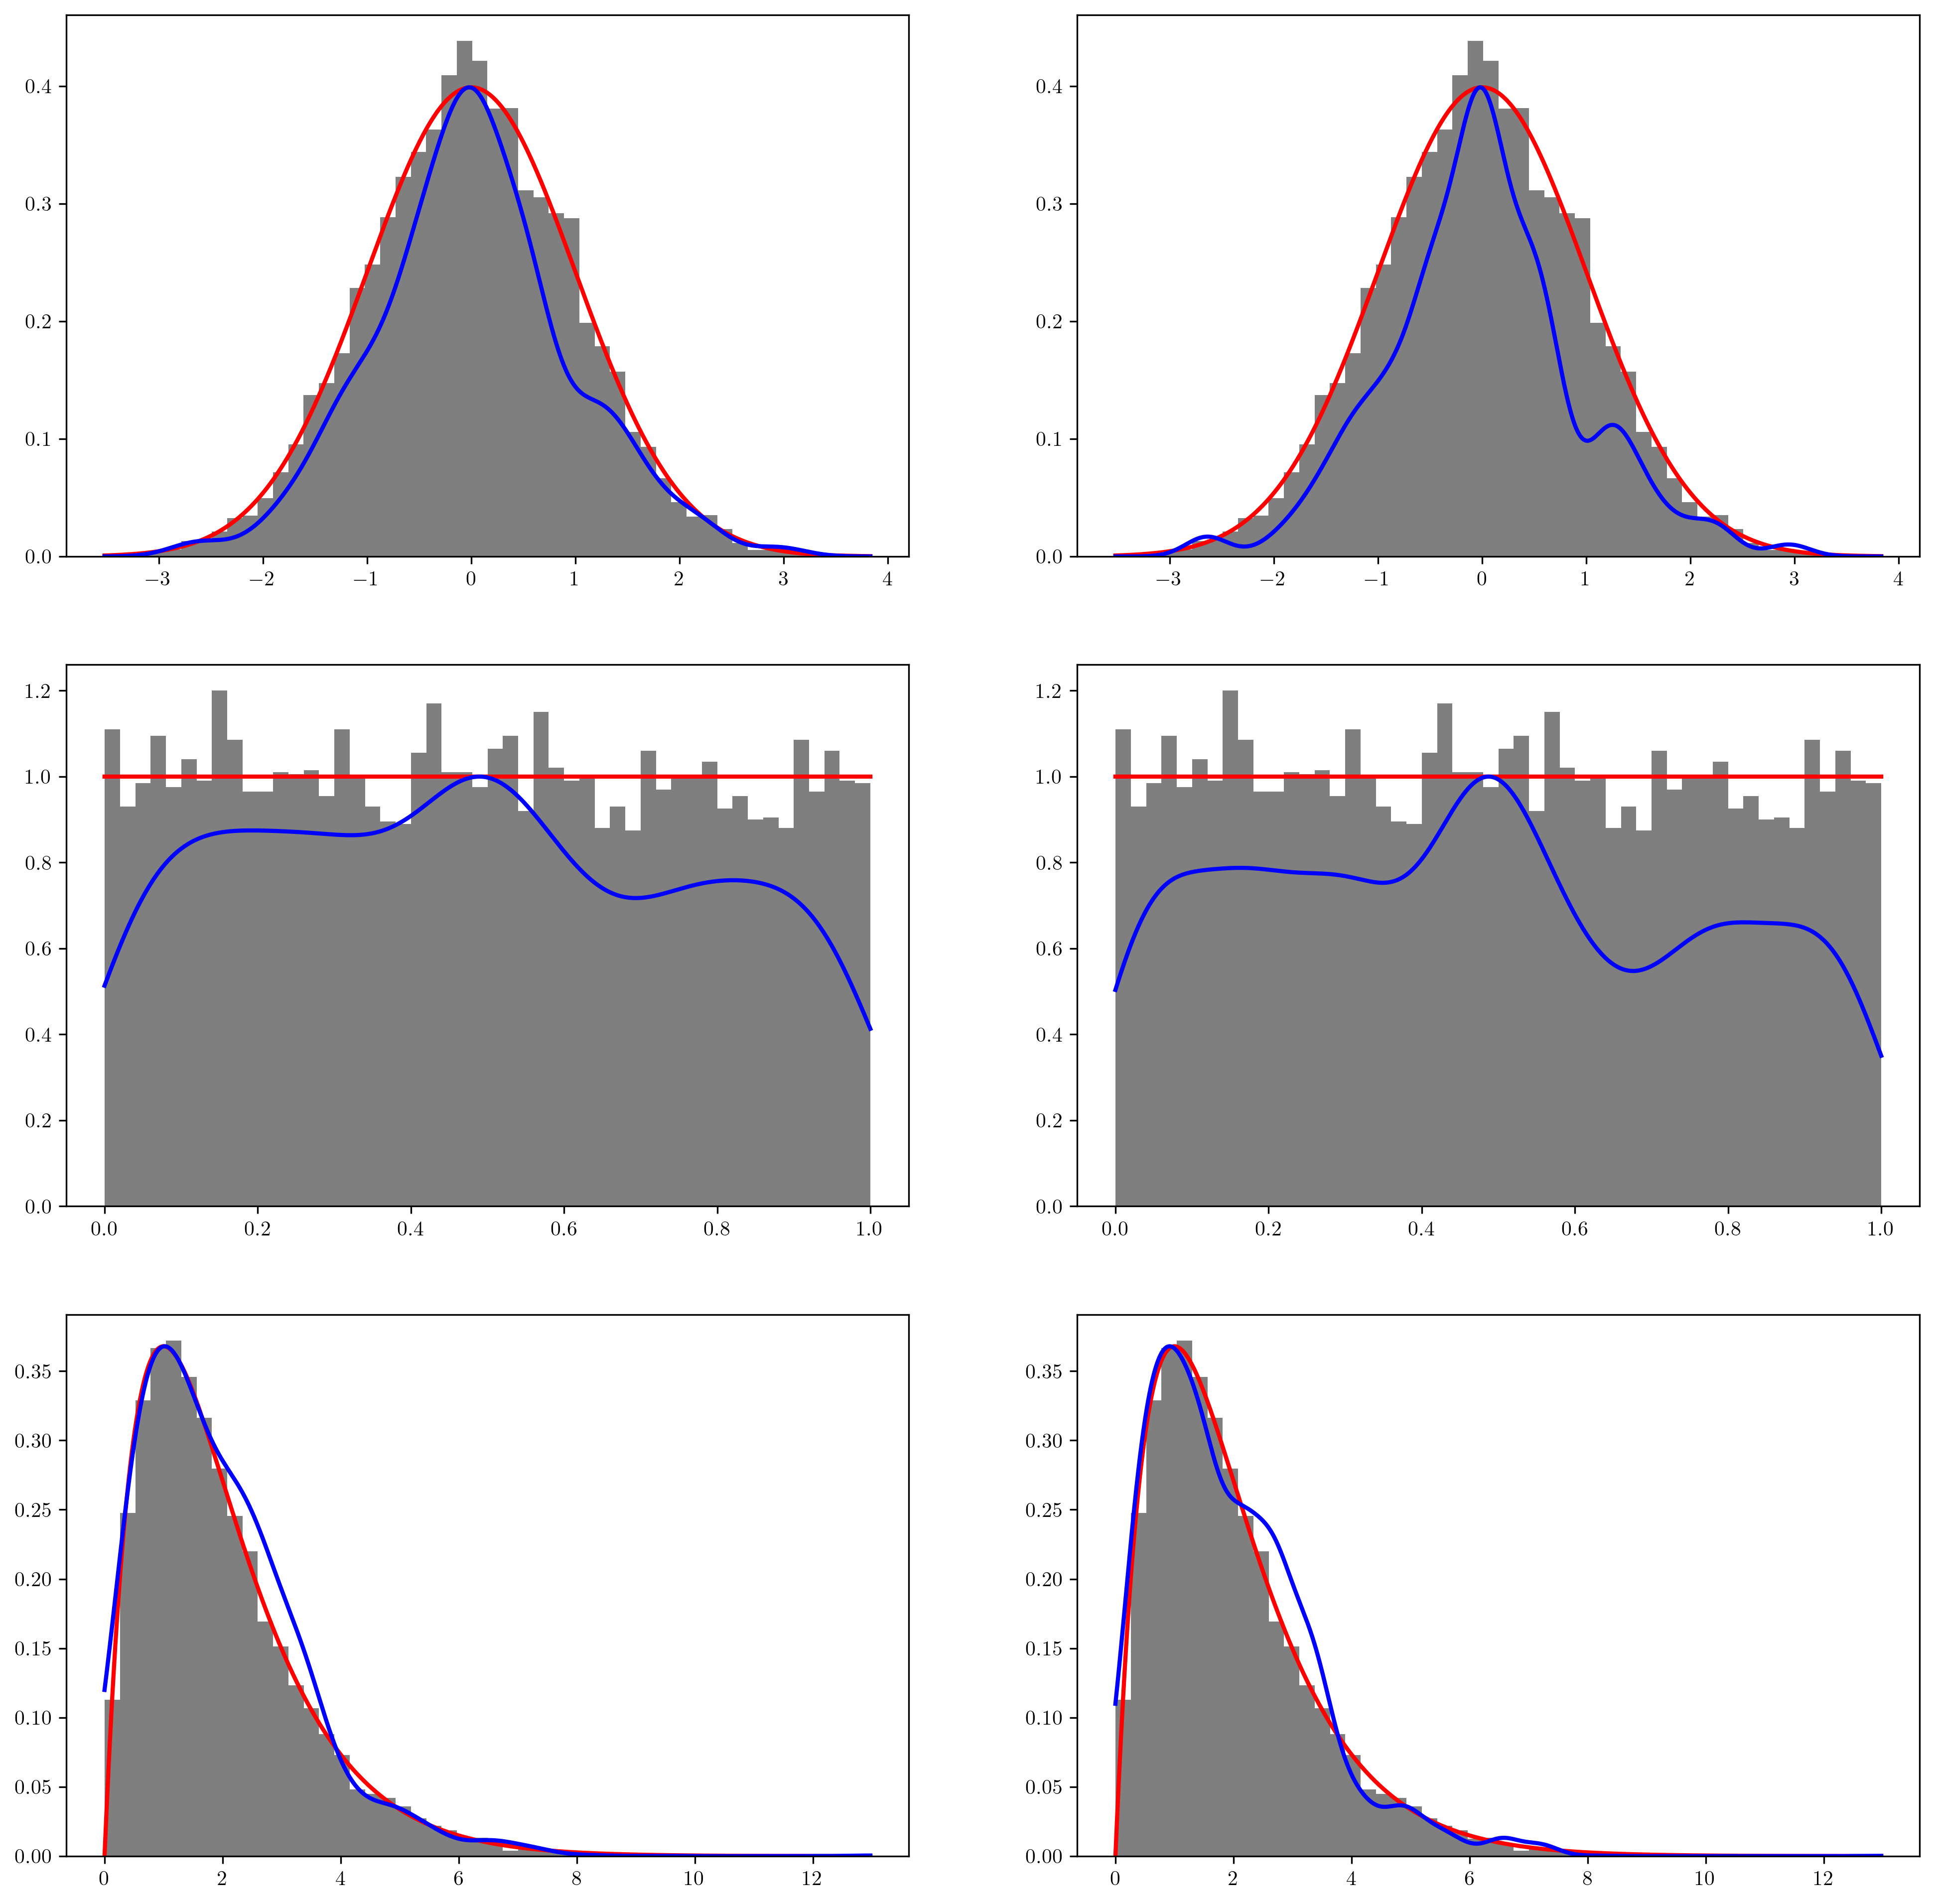

In [5]:
fig, ax = plt.subplots (3, 2, figsize=(16, 16), dpi=300, facecolor="white")

# Plotting histograms
ax[0, 0].hist(g_samples, bins=50, density=True, color='black', alpha=0.5)
ax[0, 1].hist(g_samples, bins=50, density=True, color='black', alpha=0.5)
ax[1, 0].hist(u_samples, bins=50, density=True, color='black', alpha=0.5)
ax[1, 1].hist(u_samples, bins=50, density=True, color='black', alpha=0.5)
ax[2, 0].hist(y_samples, bins=50, density=True, color='black', alpha=0.5)
ax[2, 1].hist(y_samples, bins=50, density=True, color='black', alpha=0.5)

x = np.linspace(min(g_samples), max(g_samples), ndata)
y = np.linspace(0, 1, ndata)
z = np.linspace(0, max(y_samples), ndata)

# Plotting distributions
ax[0, 0].plot(x, gaussian_pdf(x), color='red', linewidth=2)
ax[0, 1].plot(x, gaussian_pdf(x), color='red', linewidth=2)
ax[1, 0].plot(y, uniform_pdf(y), color='red', linewidth=2)
ax[1, 1].plot(y, uniform_pdf(y), color='red', linewidth=2)
ax[2, 0].plot(z, gamma_pdf(z), color='red', linewidth=2)
ax[2, 1].plot(z, gamma_pdf(z), color='red', linewidth=2)

# Plotting KDEs
g_kde_control = []
g_kde_test    = []
u_kde_control = []
u_kde_test    = []
y_kde_control = []
y_kde_test    = []

for i in range(ndata):
    g_kde_control.append(kde_control.eval(Ncm.Vector.new_array([x[i], 0, 0])))
    g_kde_test.append(kde_test.eval(Ncm.Vector.new_array([x[i], 0, 0])))
    u_kde_control.append(kde_control.eval(Ncm.Vector.new_array([0, y[i], 0])))
    u_kde_test.append(kde_test.eval(Ncm.Vector.new_array([0, y[i], 0])))
    y_kde_control.append(kde_control.eval(Ncm.Vector.new_array([0, 0, z[i]])))
    y_kde_test.append(kde_test.eval(Ncm.Vector.new_array([0, 0, z[i]])))

g_kde_control = [g * (max(gaussian_pdf(x))/max(g_kde_control)) for g in g_kde_control]
g_kde_test    = [g * (max(gaussian_pdf(x))/max(g_kde_test)) for g in g_kde_test]
u_kde_control = [u * (max(uniform_pdf(y))/max(u_kde_control)) for u in u_kde_control]
u_kde_test    = [u * (max(uniform_pdf(y))/max(u_kde_test)) for u in u_kde_test]
y_kde_control = [y * (max(gamma_pdf(z))/max(y_kde_control)) for y in y_kde_control]
y_kde_test    = [y * (max(gamma_pdf(z))/max(y_kde_test)) for y in y_kde_test]

ax[0, 0].plot(x, g_kde_control, color='blue', linewidth=2)
ax[0, 1].plot(x, g_kde_test, color='blue', linewidth=2)
ax[1, 0].plot(y, u_kde_control, color='blue', linewidth=2)
ax[1, 1].plot(y, u_kde_test, color='blue', linewidth=2)
ax[2, 0].plot(z, y_kde_control, color='blue', linewidth=2)
ax[2, 1].plot(z, y_kde_test, color='blue', linewidth=2)